In [ ]:
!pip install kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download shuvoalok/ck-dataset

  0% 0.00/1.80M [00:00<?, ?B/s]
100% 1.80M/1.80M [00:00<00:00, 175MB/s]


In [ ]:
! unzip ck-dataset.zip -d ck_data

In [ ]:
import os
import math
import numpy as np
import cv2

import seaborn as sns
import tensorflow as tf
import pandas as pd

from keras.utils import to_categorical
from matplotlib import pyplot

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.applications.mobilenet import MobileNet
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

In [ ]:
INPUT_PATH = "/content/ck_data"

In [ ]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + "/" + dir_ + '/'):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {total_images}")

fear has 75 number of images
anger has 135 number of images
sadness has 84 number of images
happy has 207 number of images
contempt has 54 number of images
disgust has 177 number of images
surprise has 249 number of images

total images are 981


In [ ]:
TOP_EMOTIONS = ['fear', 'anger', 'sadness', 'happy', 'contempt', 'disgust', 'surprise']

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + "/" + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + "/" + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

In [ ]:
label_to_text

{0: 'fear',
 1: 'anger',
 2: 'sadness',
 3: 'happy',
 4: 'contempt',
 5: 'disgust',
 6: 'surprise'}

In [ ]:
img_label = to_categorical(img_label)
img_label.shape

(981, 7)

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((882, 48, 48, 3), (99, 48, 48, 3), (882, 7), (99, 7))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
import keras
vgg = keras.applications.VGG19(weights = 'imagenet',include_top = False,input_shape = (img_width, img_height, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def get_model(build,classes):
    model=build.layers[-2].output
    model=GlobalAveragePooling2D()(model)
    model=Dense(classes,activation='softmax',name='output_layer')(model)

    return model

In [ ]:
head = get_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11,verbose = 1, restore_best_weights = True,)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 7,min_lr = 1e-7,verbose = 1,)
callbacks = [early_stopping,lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)
train_datagen.fit(X_train)


batch_size = 256
epochs = 3

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_test, y_test),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = 20,
                                       callbacks = callbacks)

Epoch 1/20
3/3 [==============================] - 25s 3s/step - loss: 1.9612 - accuracy: 0.2086 - val_loss: 1.7951 - val_accuracy: 0.2929 - lr: 1.0000e-04
Epoch 2/20
3/3 [==============================] - 1s 312ms/step - loss: 1.7582 - accuracy: 0.3311 - val_loss: 1.7024 - val_accuracy: 0.3131 - lr: 1.0000e-04
Epoch 3/20
3/3 [==============================] - 1s 317ms/step - loss: 1.6830 - accuracy: 0.3673 - val_loss: 1.4481 - val_accuracy: 0.4848 - lr: 1.0000e-04
Epoch 4/20
3/3 [==============================] - 1s 323ms/step - loss: 1.4040 - accuracy: 0.5102 - val_loss: 1.0553 - val_accuracy: 0.6263 - lr: 1.0000e-04
Epoch 5/20
3/3 [==============================] - 1s 293ms/step - loss: 1.2507 - accuracy: 0.5703 - val_loss: 0.9606 - val_accuracy: 0.6162 - lr: 1.0000e-04
Epoch 6/20
3/3 [==============================] - 1s 379ms/step - loss: 1.1253 - accuracy: 0.5998 - val_loss: 0.9920 - val_accuracy: 0.6263 - lr: 1.0000e-04
Epoch 7/20
3/3 [==============================] - 1s 290ms/s

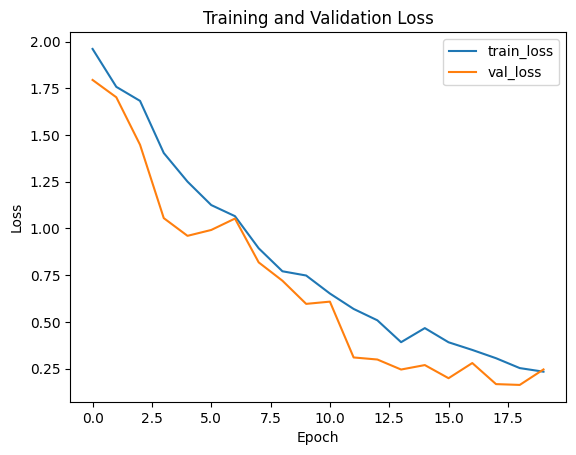

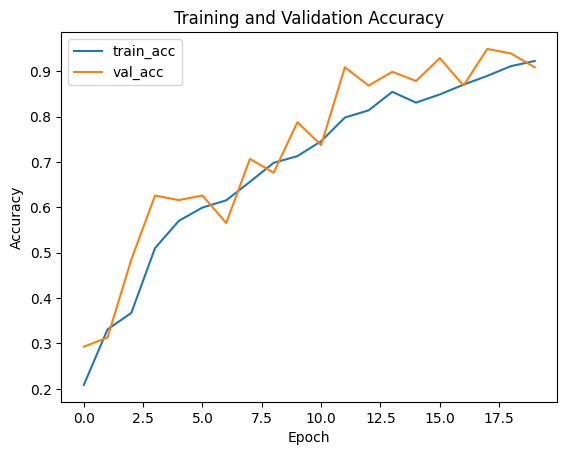

In [ ]:
import matplotlib.pyplot as plt
def plot(history):
    # Plot loss
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot(history)

In [ ]:
pred = model.predict(X_train)
pred_FER = []
for p in pred:
  max = p[0]
  index = 0
  for i, a in enumerate(p):
    if a > max:
      max = a
      index = i
  pred_FER.append(index)

28/28 [==============================] - 1s 35ms/step


In [ ]:
train_y = []
for p in y_train:
  index = 0
  for i, a in enumerate(p):
    if a==1:
      index = i
  train_y.append(index)

In [ ]:
from sklearn.metrics import classification_report
print("MobileNET in CK: ")
print(classification_report(pred_FER, train_y))

MobileNET in CK: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.43      0.98      0.60        53
           2       0.99      0.54      0.70       138
           3       1.00      1.00      1.00       186
           4       0.90      0.88      0.89        50
           5       0.99      0.96      0.98       165
           6       0.99      1.00      0.99       222

    accuracy                           0.91       882
   macro avg       0.90      0.91      0.88       882
weighted avg       0.95      0.91      0.92       882



##FER Dataset

In [ ]:
! kaggle datasets download msambare/fer2013
! unzip fer2013.zip -d fer2013_data

Streaming output truncated to the last 5000 lines.
  inflating: fer2013_data/train/sad/Training_65242339.jpg  
  inflating: fer2013_data/train/sad/Training_65267116.jpg  
  inflating: fer2013_data/train/sad/Training_65275626.jpg  
  inflating: fer2013_data/train/sad/Training_6529266.jpg  
  inflating: fer2013_data/train/sad/Training_65329617.jpg  
  inflating: fer2013_data/train/sad/Training_65338712.jpg  
  inflating: fer2013_data/train/sad/Training_65338797.jpg  
  inflating: fer2013_data/train/sad/Training_65387162.jpg  
  inflating: fer2013_data/train/sad/Training_65404494.jpg  
  inflating: fer2013_data/train/sad/Training_65426218.jpg  
  inflating: fer2013_data/train/sad/Training_65430136.jpg  
  inflating: fer2013_data/train/sad/Training_65437377.jpg  
  inflating: fer2013_data/train/sad/Training_6545735.jpg  
  inflating: fer2013_data/train/sad/Training_65463385.jpg  
  inflating: fer2013_data/train/sad/Training_65473985.jpg  
  inflating: fer2013_data/train/sad/Training_655028

In [ ]:
train_dir = '/content/fer2013_data/train'
test_dir = '/content/fer2013_data/test'

In [ ]:
train_images = 0
for dir_ in os.listdir(train_dir):
    count = 0
    for f in os.listdir(train_dir + "/" + dir_ + '/'):
        count += 1
        train_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {train_images}")

fear has 4097 number of images
sad has 4830 number of images
happy has 7215 number of images
angry has 3995 number of images
neutral has 4965 number of images
disgust has 436 number of images
surprise has 3171 number of images

total images are 28709


In [ ]:
test_images = 0
for dir_ in os.listdir(test_dir):
    count = 0
    for f in os.listdir(test_dir + "/" + dir_ + '/'):
        count += 1
        test_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {test_images}")

fear has 1024 number of images
sad has 1247 number of images
happy has 1774 number of images
angry has 958 number of images
neutral has 1233 number of images
disgust has 111 number of images
surprise has 831 number of images

total images are 7178


In [ ]:
TOP_EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [ ]:
X_train = np.empty(shape=(train_images,48,48,3))
y_train = np.empty(shape=(train_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(train_dir):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(train_dir + "/" + dir_ + "/"):
            X_train[i] = cv2.imread(train_dir + "/" + dir_ + "/" + f)
            y_train[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

X_train.shape

loaded all fear images to numpy arrays
loaded all sad images to numpy arrays
loaded all happy images to numpy arrays
loaded all angry images to numpy arrays
loaded all neutral images to numpy arrays
loaded all disgust images to numpy arrays
loaded all surprise images to numpy arrays


(28709, 48, 48, 3)

In [ ]:
X_test = np.empty(shape=(test_images,48,48,3))
y_test = np.empty(shape=(test_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(test_dir):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(test_dir + "/" + dir_ + "/"):
            X_test[i] = cv2.imread(test_dir + "/" + dir_ + "/" + f)
            y_test[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

X_test.shape

loaded all fear images to numpy arrays
loaded all sad images to numpy arrays
loaded all happy images to numpy arrays
loaded all angry images to numpy arrays
loaded all neutral images to numpy arrays
loaded all disgust images to numpy arrays
loaded all surprise images to numpy arrays


(7178, 48, 48, 3)

In [ ]:
label_to_text

{0: 'fear',
 1: 'sad',
 2: 'happy',
 3: 'angry',
 4: 'neutral',
 5: 'disgust',
 6: 'surprise'}

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape

(28709, 7)

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
import keras
vgg = keras.applications.VGG19(weights = 'imagenet',include_top = False,input_shape = (img_width, img_height, 3))

In [ ]:
head = get_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11,verbose = 1, restore_best_weights = True,)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 7,min_lr = 1e-7,verbose = 1,)
callbacks = [early_stopping,lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)
train_datagen.fit(X_train)


batch_size = 256
epochs = 3

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_test, y_test),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = 50,
                                       callbacks = callbacks)

Epoch 1/50
112/112 [==============================] - 59s 485ms/step - loss: 1.6391 - accuracy: 0.3442 - val_loss: 1.3687 - val_accuracy: 0.4749 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - 37s 327ms/step - loss: 1.3265 - accuracy: 0.4922 - val_loss: 1.2444 - val_accuracy: 0.5252 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - 41s 369ms/step - loss: 1.2156 - accuracy: 0.5379 - val_loss: 1.1276 - val_accuracy: 0.5684 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - 48s 424ms/step - loss: 1.1389 - accuracy: 0.5687 - val_loss: 1.0947 - val_accuracy: 0.5747 - lr: 1.0000e-04
Epoch 5/50
112/112 [==============================] - 45s 397ms/step - loss: 1.0958 - accuracy: 0.5875 - val_loss: 1.0538 - val_accuracy: 0.6009 - lr: 1.0000e-04
Epoch 6/50
112/112 [==============================] - 35s 310ms/step - loss: 1.0649 - accuracy: 0.5983 - val_loss: 1.0301 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 7/50
112/112 [========

In [ ]:
model_json = model.to_json()
with open("model_VGG19.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_VGG19.h5")
print("Saved model to disk")

In [ ]:
pred = model.predict(X_test)
pred_FER = []
for p in pred:
  max = p[0]
  index = 0
  for i, a in enumerate(p):
    if a > max:
      max = a
      index = i
  pred_FER.append(index)

test_y = []
for p in y_test:
  index = 0
  for i, a in enumerate(p):
    if a==1:
      index = i
  test_y.append(index)

225/225 [==============================] - 3s 14ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_FER, test_y))

              precision    recall  f1-score   support

           0       0.51      0.59      0.55       898
           1       0.50      0.58      0.54      1079
           2       0.86      0.87      0.87      1754
           3       0.64      0.55      0.59      1124
           4       0.66      0.58      0.62      1391
           5       0.67      0.84      0.74        88
           6       0.81      0.79      0.80       844

    accuracy                           0.68      7178
   macro avg       0.66      0.69      0.67      7178
weighted avg       0.68      0.68      0.68      7178



In [ ]:
pred = model.predict(X_train)
pred_FER = []
for p in pred:
  max = p[0]
  index = 0
  for i, a in enumerate(p):
    if a > max:
      max = a
      index = i
  pred_FER.append(index)

train_y = []
for p in y_train:
  index = 0
  for i, a in enumerate(p):
    if a==1:
      index = i
  train_y.append(index)

898/898 [==============================] - 13s 14ms/step


In [ ]:
print(classification_report(pred_FER, train_y))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4034
           1       0.91      0.96      0.94      4574
           2       0.98      0.99      0.98      7183
           3       0.97      0.92      0.95      4187
           4       0.97      0.93      0.95      5167
           5       0.99      0.97      0.98       444
           6       0.96      0.97      0.96      3120

    accuracy                           0.95     28709
   macro avg       0.96      0.95      0.95     28709
weighted avg       0.95      0.95      0.95     28709



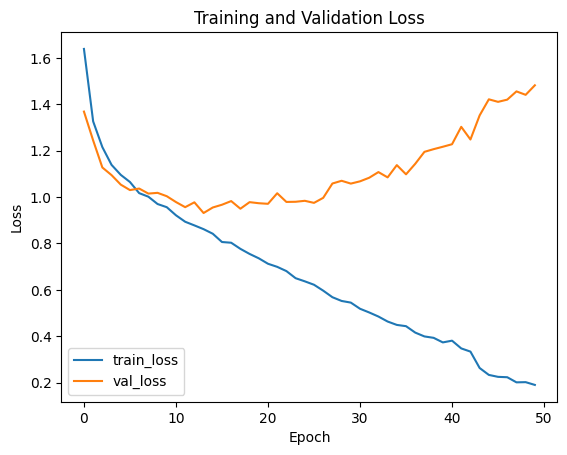

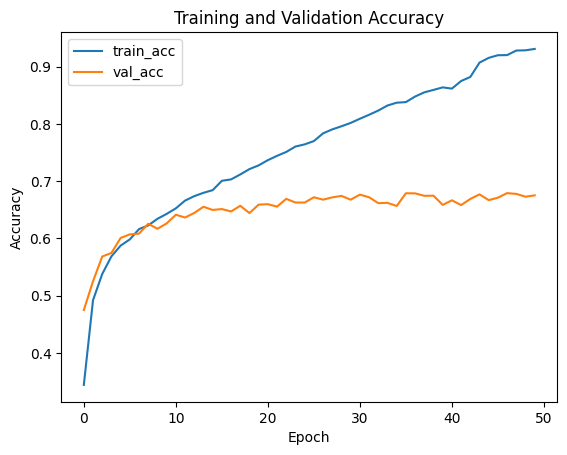

In [ ]:
import matplotlib.pyplot as plt
def plot(history):
    # Plot loss
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot(history)